In [1]:
import tensorflow as tf
from keras.initializers import Initializer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

#Select GPU if can
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPU, 1 Logical GPU


In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten train data
x_train, x_test = x_train / 255.0, x_test / 255.0
train_images = x_train.reshape((60000, 28*28)).astype('float32')

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
#Decompose the matrix using svd
U, S, VT = np.linalg.svd(train_images, full_matrices=False)

#Use the first few singular vectors (VT matrix)
class SVDInitializer(Initializer):
    def __init__(self, svd_components):
        self.svd_components = svd_components

    def __call__(self, shape, dtype=None):

        assert shape[0] <= self.svd_components.shape[1]
        return self.svd_components[:shape[0], :shape[1]]


In [4]:
# Reshape data for SVD
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)


n_components = 12*12
# Apply SVD both for data and kernel init with 12*12 features(144 total from 784)
svd = TruncatedSVD(n_components=n_components)
x_train_svd = svd.fit_transform(x_train_flat)
x_test_svd = svd.transform(x_test_flat)
svd_initializer = SVDInitializer(VT[:n_components].T)

# Reshape data to 3 dims for augmentation method
x_train_svd = x_train_svd.reshape(x_train.shape[0], n_components, 1, 1)
x_test_svd = x_test_svd.reshape(x_test.shape[0], n_components, 1, 1)


In [5]:
# Convert the data to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_svd, y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((x_test_svd, y_test))

# Augment data
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label
train_dataset = train_dataset.map(augment)


In [6]:
#Final model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_components, 1, 1)),
    tf.keras.layers.Dense(128, activation='relu',kernel_initializer=svd_initializer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
#Fit model
history = model.fit(
    train_dataset.batch(32),
    validation_data=test_dataset.batch(32),
    epochs=25)


Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.1297 - val_accuracy: 0.9815
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.1375 - val_accuracy: 0.9813
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.1327 - val_accuracy: 0.9812
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.1371 - val_accuracy: 0.9808
Epoch 5/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.1420 - val_accuracy: 0.9816
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0.1442 - val_accuracy: 0.9795
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.1438 - val_accuracy:

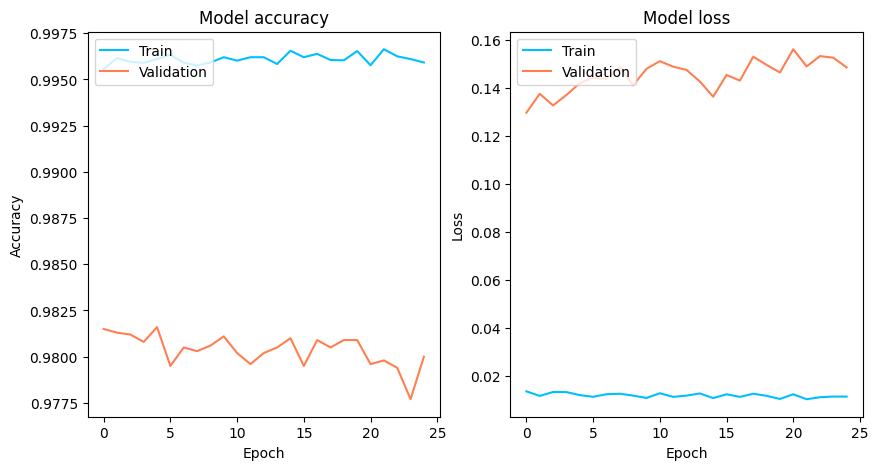

In [10]:
#Plot learnring curve
def plot_learning_curve(hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    train_color = '#00bfff'  # Deep sky blue
    val_color = '#ff7f50'    # Coral


    axs[0].plot(hist.history['accuracy'], color=train_color)
    axs[0].plot(hist.history['val_accuracy'], color=val_color)
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(hist.history['loss'], color=train_color)
    axs[1].plot(hist.history['val_loss'], color=val_color)
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_learning_curve(history)

In [ ]:
model.summary()